<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Импорт данных + Тех. анализ

In [1]:
#!pip install apimoex

In [73]:
import requests
import numpy as np
import apimoex
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import talib as ta
from bs4 import BeautifulSoup
import re

In [3]:
list(ta.get_function_groups().keys()) #возможные функции библиотеки для тех. анализа 

['Cycle Indicators',
 'Math Operators',
 'Math Transform',
 'Momentum Indicators',
 'Overlap Studies',
 'Pattern Recognition',
 'Price Transform',
 'Statistic Functions',
 'Volatility Indicators',
 'Volume Indicators']

In [55]:
stock_quotes = ['GAZP', 'YNDX', 'RUAL', 'IRAO', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'PLZL', 'ROSN', 'SBER',
               'SNGS', 'TATN','CHMF']

In [5]:
# with requests.Session() as session:
#     for elem in stock_quotes:
#         data = apimoex.get_board_history(session, elem)
#         df_2 = pd.DataFrame(data)
#         df_2.rename(columns = {'CLOSE':elem}, inplace = True)
#         print(elem, df_2['TRADEDATE'][0])

In [6]:
df = pd.DataFrame({"begin": pd.date_range(start='2015-03-30', freq='1d', end=date.today()- timedelta(days=1))})

In [7]:
df.head(3)

,begin
0,2015-03-30
1,2015-03-31
2,2015-04-01


In [8]:
with requests.Session() as session:
    for elem in stock_quotes:
        data = apimoex.get_market_candles(session, elem, interval = 24, columns = ('begin', 'open', 'close', 'high', 'low'),
                                          start = '2015-03-30', end = date.today() - timedelta(days=1)) #задаём нужные параметры
        data = pd.DataFrame(data)
        data.rename(columns = {'open':'open_'+elem, 'close': 'close_'+elem, 'high': 'high_'+elem, 'low': 'low_'+elem}, inplace = True)
        
        #немного переименовал колонки, чтобы было удобнее
        data['begin'] = data['begin'].apply(lambda x: x[:11]) #берём только нужные элементы даты, без часов, минут и т.д.
        data['begin'] = pd.to_datetime(data['begin']) #переводим в нужный формат
        df = pd.merge(df, data, on='begin', how='inner')
    
for elem in stock_quotes:
    #расчёт индикаторов тех. анализа  (Осциляторы)
    df['RSI_'+elem] = ta.RSI(df['close_'+elem]) #расчитали первый технический индикатор (RSI)
        
    slowk, slowd = ta.STOCH(df['high_'+elem], df['low_'+elem], df['close_'+elem]) #расчитали первый технический индикатор (STOCHASTIC)
    df['STOCH_slowk'+elem] = slowk
    df['STOCH_slowd'+elem] = slowd
        
    macd, macdsignal, macdhist = ta.MACD(df['close_'+elem])
    df['MACD_'+elem] = macd
    df['MACDSIGNAL_'+elem] = macdsignal
    df['MACDHIST_'+elem] = macdhist
#----------------------------------------------------------------------------------------    
    #Расчёт SMA, EMA, Bollinger
    df['SMA_'+elem] = ta.SMA(df['close_'+elem]) #Рассчитали простую скользящую среднюю 
    df['EMA_'+elem] = ta.EMA(df['close_'+elem]) #Рассчитали экспоненциальную скользящую среднюю
    
    upperband, middleband, lowerband = ta.BBANDS(df['close_'+elem]) #Рассчитали полосы боллиндежра
    df['BOLLINGER_up_'+elem] = upperband
    df['BOOLLINGER_low_'+elem] = lowerband
    df['BOOLLINGER_mid_'+elem] = middleband
#-----------------------------------------------------------------------------------------------------------   
    #Анализируем наличие свечных паттернов
    threeLineStrike = ta.CDL3LINESTRIKE(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['3_Line_Strike_'+elem] = threeLineStrike
    
    eveningStar = ta.CDLEVENINGSTAR(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])#вечерняя звезда
    df['Evening_Star_'+elem] = eveningStar 
    
    hammer = ta.CDLHAMMER(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['Hammer_'+elem] = hammer 
    
    morningStar = ta.CDLMORNINGSTAR(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['Morning_Star_'+elem] = morningStar 

#----------------------------------------------------------------------------------------------------------
#Вроде, весб тех. анализ импортнул 

C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12660/4036580460.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BOOLLINGER_low_'+elem] = lowerband
C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12660/4036580460.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['BOOLLINGER_mid_'+elem] = middleband
C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12660/4036580460.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [9]:
df

,begin,open_GAZP,close_GAZP,high_GAZP,low_GAZP,open_YNDX,close_YNDX,high_YNDX,low_YNDX,open_RUAL,...,MACDHIST_CHMF,SMA_CHMF,EMA_CHMF,BOLLINGER_up_CHMF,BOOLLINGER_low_CHMF,BOOLLINGER_mid_CHMF,3_Line_Strike_CHMF,Evening_Star_CHMF,Hammer_CHMF,Morning_Star_CHMF
0,2015-03-30,134.50,137.00,137.88,134.24,877.0,887.0,903.0,877.0,37.000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2015-03-31,136.85,138.90,139.19,136.60,891.0,893.0,895.0,878.0,36.850,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2015-04-01,138.45,143.00,143.20,137.57,885.0,902.0,903.0,883.0,36.000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2015-04-02,143.83,143.90,144.88,142.32,902.0,919.0,920.0,887.0,36.005,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2015-04-03,144.00,143.94,145.65,143.02,924.0,940.0,946.0,922.0,36.000,...,NaN,NaN,NaN,663.243602,634.176398,648.71,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2023-12-18,164.99,167.00,167.32,164.99,2228.8,2250.4,2271.0,2217.4,35.300,...,2.311726,1307.160000,1295.389203,1299.768270,1203.991730,1251.88,0,0,0,0
2180,2023-12-19,167.17,165.48,168.89,165.12,2250.2,2242.2,2274.0,2231.8,35.415,...,5.904098,1304.346667,1296.151190,1327.890095,1202.509905,1265.20,0,0,0,0
2181,2023-12-20,165.33,163.56,165.33,163.12,2247.0,2288.8,2318.8,2242.6,35.350,...,9.527450,1302.840000,1298.334984,1358.477727,1205.762273,1282.12,0,0,0,0
2182,2023-12-21,163.32,161.57,163.71,161.19,2279.0,2267.2,2286.8,2245.2,35.105,...,11.924716,1302.086667,1300.803694,1355.785505,1256.454495,1306.12,0,0,0,0


In [10]:
df.isna().sum()#Пропуски должны быть, не нужно их удалять. Индикаторам нужны первые дни, чтобы хоть что-то расчитать 

begin                  0
open_GAZP              0
close_GAZP             0
high_GAZP              0
low_GAZP               0
                      ..
BOOLLINGER_mid_CHMF    4
3_Line_Strike_CHMF     0
Evening_Star_CHMF      0
Hammer_CHMF            0
Morning_Star_CHMF      0
Length: 286, dtype: int64

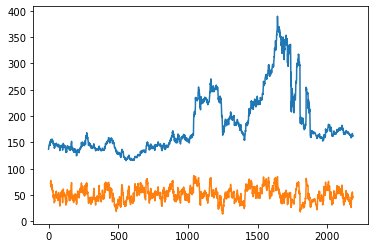

In [11]:
plt.plot(list(df['close_GAZP']))
plt.plot(list(df['RSI_GAZP']))
#Нужно явно что-то красивее matplotlib-а. Нижний график должен быть с отдельной осью, чуть меньше и ниже основного графика

In [12]:
df.to_csv("fin_quotes_per_day.csv", index=False)

# Свечные паттерны 

In [82]:
#пока не работает, ручно паттерн
# def detect_head_shoulder(df, window=3):
# # Define the rolling window
#     for elem in stock_quotes:
#         roll_window = window
#         # Create a rolling window for High and Low
#         df['high_roll_max_'+elem] = df['high_'+elem].rolling(window=roll_window).max()
#         df['low_roll_min_'+elem] = df['low_'+elem].rolling(window=roll_window).min()
#         # Create a boolean mask for Head and Shoulder pattern
#         mask_head_shoulder = ((df['high_roll_max_'+elem] > df['high_'+elem].shift(1)) & (df['high_roll_max_'+elem] > df['high_'+elem].shift(-1)) & (df['high_'+elem] < df['high_'+elem].shift(1)) & (df['high_'+elem] < df['high_'+elem].shift(-1)))
#         # Create a boolean mask for Inverse Head and Shoulder pattern
#         mask_inv_head_shoulder = ((df['low_roll_min_'+elem] < df['low_'+elem].shift(1)) & (df['low_roll_min_'+elem] < df['low_'+elem].shift(-1)) & (df['low_'+elem] > df['low_'+elem].shift(1)) & (df['low_'+elem] > df['low_'+elem].shift(-1)))
#         # Create a new column for Head and Shoulder and its inverse pattern and populate it using the boolean masks
#         df['head_shoulder_pattern_'+elem] = np.nan
#         df.loc[mask_head_shoulder, 'head_shoulder_pattern_'+elem] = 'Head and Shoulder'
#         df.loc[mask_inv_head_shoulder, 'head_shoulder_pattern_'+elem] = 'Inverse Head and Shoulder'
#     return df

# Визуализируем  всё

In [31]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('GAZP_price', 'Indicator'), 
               row_width=[0.2, 0.7])


candle_graph = go.Candlestick( #обязательно должен выдавать такой график с ценой, без индикаторов, если пользователь ничего не указал
                            x=df['begin'],
                            open=df['open_GAZP'],
                            high=df['high_GAZP'],
                            low=df['low_GAZP'],
                            close=df['close_GAZP'])
                            # рисуем основной график 
fig.add_trace(candle_graph, row = 1, col = 1) #отрисовываем основной график

#ещё бы добавить возможность отрисовки не всех годов, а только указанны, например 5 лет, 3 года, 1 год(последний) и т.д.
#Далее, в зависимости от того, что выбрал пользователь (какие индикаторы), их нужно добавлять на график, ниже я написал код, как
#это сделать 



#Рисуем паттерны --------------------------------------------------------------------
#вставил пока довольно базовые паттерны

Line_Strike = df[df['3_Line_Strike_GAZP']!=0]
#fig.add_trace(go.Scatter(x=Line_Strike['begin'], y=Line_Strike['high_GAZP'], mode='markers', name='3_Line_Strike', 
#                         marker=dict(symbol='circle', size=10, color = 'blue')), row = 1, col = 1)

evening_Star = df[df['Evening_Star_GAZP']!=0]
#fig.add_trace(go.Scatter(x=evening_Star['begin'], y=evening_Star['high_GAZP'], mode='markers', name='evening_Star', 
#                         marker=dict(symbol='circle', size=10, color = 'yellow')), row = 1, col = 1)

hammer = df[df['Hammer_GAZP']!=0]
#fig.add_trace(go.Scatter(x=hammer['begin'], y=hammer['high_GAZP'], mode='markers', name='Hammer', 
#                         marker=dict(symbol='circle', size=10, color = 'orange')), row = 1, col = 1)

morningStar = df[df['Morning_Star_GAZP']!=0]
#fig.add_trace(go.Scatter(x=morningStar['begin'], y=morningStar['high_GAZP'], mode='markers', name='morning_Star', 
#                         marker=dict(symbol='circle', size=10, color = 'purple')), row = 1, col = 1)

#чтобы отрисовать, просто уберите # с fig.add_trace и ниже


#Тут всё Готово!!!!
#------------------------------------------------------------------------------------------

sma = go.Scatter(x=df['begin'], #отрисовываем скользящую среднюю
                 y=df["SMA_GAZP"],
                 name="SMA",
                 line=dict(color='blue')
                )

ema = go.Scatter(x=df['begin'], #отрисовываем экспоненциальную скользящую среднюю
                 y=df["EMA_GAZP"],
                 line=dict(color='yellow'),
                 name = 'EMA'
                )

#fig.add_trace(sma, row=1, col=1)
#fig.add_trace(ema, row=1, col=1) - отрисовать графики
#Тут всё Готово!!!!
#----------------------------------------------------------------------------------------------

Bollinger_up = go.Scatter(x=df['begin'], #отрисовываем верхнюю полусу боллинджера
                 y=df["BOLLINGER_up_GAZP"],
                 line=dict(color='blue'),
                 name = 'BOLLINGER_up'
                )

Bollinger_low = go.Scatter(x=df['begin'], #отрисовываем верхнюю полусу боллинджер
                 y=df["BOOLLINGER_low_GAZP"],
                 line=dict(color='blue'),
                 name = 'BOLLINGER_low'
                )

Bollinger_mid = go.Scatter(x=df['begin'], #отрисовываем серединную полусу боллинджер
                 y=df["BOOLLINGER_mid_GAZP"],
                 line=dict(color='orange'),
                 name = 'BOLLINGER_mid'
                )

#fig.add_trace(Bollinger_up, row=1, col=1) - отрисовать графики
#fig.add_trace(Bollinger_low, row=1, col=1)
#fig.add_trace(Bollinger_mid, row=1, col=1)
#Тут всё Готово!!!!
#----------------------------------------------------------------------------------------

#рисуем оссцилятор 
rsi = go.Scatter(x=df['begin'], y=df['RSI_GAZP'], line=dict(color='purple'), name='RSI')
#Отрисовать RSI:
#fig.add_trace(rsi, row = 2, col = 1)
#fig.add_hline(y=20, row = 2, col = 1, line=dict(color="gray"))
#fig.add_hline(y=80, row = 2, col = 1, line=dict(color="gray"))


macd_usual = go.Scatter(x=df['begin'], y=df['MACD_GAZP'], line=dict(color='blue'), name='MACD')
macd_signal = go.Scatter(x=df['begin'], y=df['MACDSIGNAL_GAZP'], line=dict(color='orange'), name='Signal')
macdhist_bar = go.Bar(x=df['begin'], y=df['MACDHIST_GAZP'], name='MACD Histogram', marker=dict(color='green'))

#Отрисовать MACD:
#fig.add_trace(macd_usual, row = 2, col = 1)
#fig.add_trace(macd_signal, row = 2, col = 1)
#fig.add_trace(macdhist_bar, row = 2, col = 1)




slowk_trace = go.Scatter(x=df['begin'], y=df['STOCH_slowkGAZP'], mode='lines', name='STOCH SlowK',line=dict(color='orange'))
slowd_trace = go.Scatter(x=df['begin'], y=df['STOCH_slowdGAZP'], mode='lines', name='STOCH SlowD',line=dict(color='purple'))

#Отрисовать STOCH
#fig.add_trace(slowk_trace, row=2, col=1)
#fig.add_trace(slowd_trace, row=2, col=1)
#fig.add_hline(y=20, row = 2, col = 1, line=dict(color="gray", dash="dash"))
#fig.add_hline(y=80, row = 2, col = 1, line=dict(color="gray", dash="dash"))


#Тут всё Готово!!!!
#------------------------------------------------------------------------
fig.update_layout(xaxis_rangeslider_visible=False) #дополнительные штуки для отрисовки
fig.update_layout(
    width=800, height=600,
    title="GAZP 2015 - 2023",
    yaxis_title='GAZP Stock',
)

fig.show()

#сюда можно добавить ещё один график снизу, чтобы можно было просматривать два оссцилятора 

## Идеи для доработки: (в презентацию)

1) Два или более осцилятора вместе - платно. Несколько паттернов сразу - платно. 

2) Сделать нормальные формации (проблема - нет библиотек, всё вручную).

3) Можно добавить торгового робота в функционал проекта: не осталось времени, сложно, не хватает знаний на данный момент

4) Реализовать как-то уровни поддержки и сопротивления. Сложно статистически, но такая же мегаимба как RSI

и т.д.

---------------------------------------------------------------

# Фундаментальный Анализ

In [125]:
figures_list = ['ev_ebitda', 'p_e', 'eps', 'div_yield', 'div_payout_ratio', 'debt_ebitda', 'net_debt',
               'roa', 'roe']
url_1 = 'https://smart-lab.ru/q/shares_fundamental4/?field='+'ev_ebitda'
site = requests.get(url_1)  
site 

<Response [200]>

In [126]:
site.encoding = 'utf-8'
soup = BeautifulSoup(site.text)
table = soup.find('table', class_ = 'simple-little-table little trades-table')
spisok = table.find_all('td')

In [134]:
#создаём списки для значений
value_2013 = list()
value_2014 = list()
value_2015 = list()
value_2016 = list()
value_2017 = list()
value_2018 = list()
value_2019 = list()
value_2020 = list()
value_2021 = list()
value_2022 = list()
ticrkers = list()
#задаём счётчик 
counter = -1

for elem in spisok:
    counter += 1
    if elem.text in stock_quotes:
        #собираем абсолютно все данные по годам
        ticker = elem.text
        ticrkers.append(ticker)

        value_13 = re.sub(r'[\n\r\t>]+', '', spisok[counter+3].text)
        if value_13 == '':
            value_2013.append(np.nan)
        elif value_13 != '':
            value_2013.append(float(value_13))


        value_14 = re.sub(r'[\n\r\t>]+', '', spisok[counter+4].text)
        if value_14 == '':
            value_2014.append(np.nan)
        elif value_14 != '':
            value_2014.append(float(value_14))

        value_15 = re.sub(r'[\n\r\t>]+', '', spisok[counter+5].text)
        if value_15 == '':
            value_2015.append(np.nan)
        elif value_15 != '':
            value_2015.append(float(value_15))


        value_16 = re.sub(r'[\n\r\t>]+', '', spisok[counter+6].text)
        if value_16 == '':
            value_2016.append(np.nan)
        elif value_16 != '':
            value_2016.append(float(value_16))


        value_17 = re.sub(r'[\n\r\t>]+', '', spisok[counter+7].text)
        if value_17 == '':
            value_2017.append(np.nan)
        elif value_17 != '':
            value_2017.append(float(value_17))    


        value_18 = re.sub(r'[\n\r\t>]+', '', spisok[counter+8].text)
        if value_18 == '':
            value_2018.append(np.nan)
        elif value_18 != '':
            value_2018.append(float(value_18))   


        value_19 = re.sub(r'[\n\r\t>]+', '', spisok[counter+9].text)
        if value_19 == '':
            value_2019.append(np.nan)
        elif value_19 != '':
            value_2019.append(float(value_19))    

        value_20 = re.sub(r'[\n\r\t>]+', '', spisok[counter+10].text)
        if value_20 == '':
            value_2020.append(np.nan)
        elif value_20 != '':
            value_2020.append(float(value_20))


        value_21 = re.sub(r'[\n\r\t>]+', '', spisok[counter+11].text)
        if value_21 == '':
            value_2021.append(np.nan)
        elif value_21 != '':
            value_2021.append(float(value_21))


        value_22 = re.sub(r'[\n\r\t>]+', '', spisok[counter+12].text)
        if value_22 == '':
            value_2022.append(np.nan)
        elif value_22 != '':
            value_2022.append(float(value_22))


# создаём датафрейм
df = pd.DataFrame({'tickers': ticrkers,
                   '2013': value_2013,
                   '2014': value_2014,
                   '2015': value_2015,
                   '2016': value_2016,
                   '2017': value_2017,
                   '2018': value_2018,
                   '2019': value_2019,
                   '2020': value_2020,
                   '2021': value_2021,
                   '2012': value_2022}) 
df = df.set_index('tickers')

In [146]:
#итоговая таблица (в качестве примера) (Да, там могут быть пробелы из-за проблем с фин.отчётностью компаний)
df.head()

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2012
tickers,,,,,,,,,,
GAZP,2.19,2.46,2.83,4.23,3.74,2.56,4.97,6.08,2.98,2.13
LKOH,3.31,3.11,3.38,4.61,3.75,3.40,3.29,5.38,3.10,NaN
PLZL,NaN,NaN,6.98,7.67,7.97,7.90,6.69,8.14,7.26,6.45
ROSN,5.04,5.90,5.90,6.90,5.98,4.60,4.49,8.42,5.04,1.51
CHMF,6.71,5.97,4.45,6.56,5.35,4.43,4.87,7.15,3.30,NaN


# Как это должно работать: 
1) Пользователь выбирает нужный индикатор для анализа, например ROA, и нужную компанию-(и) (индикатор, скорее всего, можно будет выбрать только один за раз! (P.S.) Названия мультипликаторов будут в таблице, которую прикреплю. 

2) К url просто прибавляется соответствующий элемент из листа figures_list, где лежат навзания мультипликаторов для ссылок

3) Дальше строится таблица, только после этого мы отображаем значения для выбранных компаний

4) Выводится соответствующая таблица с результами и графиком

In [147]:
companies_choice = ['GAZP', 'YNDX', 'RUAL'] #взял в качетсве примера, что выбрал пользователь
fig = go.Figure()
fig.update_layout(title="Анализ мультипликатора ROA",
                  xaxis_title="Года",
                  yaxis_title="Значение мультипликатора")

for comp in companies_choice:
    fig.add_trace(go.Scatter(x=df.loc[comp].index, y=df.loc[comp].values, name=comp))

fig.show()


------------------------------------------